In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

np.random.seed(42)

Step 1: Create mock data

In [ ]:

weeks = 52
data = pd.DataFrame({
    'week': np.arange(1, weeks + 1),
    'tv_spend': np.random.uniform(20000, 50000, weeks),
    'search_spend': np.random.uniform(10000, 30000, weeks),
    'email_spend': np.random.uniform(5000, 15000, weeks),
    'gluten_free_products': np.linspace(5, 20, weeks)  # gradually increasing product count
})


Apply adstock effect function

In [ ]:

def adstock(series, rate=0.5):
    result = np.zeros_like(series)
    for i in range(len(series)):
        if i == 0:
            result[i] = series[i]
        else:
            result[i] = series[i] + rate * result[i-1]
    return result

data['tv_adstock'] = adstock(data['tv_spend'], rate=0.6)
data['search_adstock'] = adstock(data['search_spend'], rate=0.4)
data['email_adstock'] = adstock(data['email_spend'], rate=0.3)

Generate sales with some coefficients + noise

In [ ]:

data['sales'] = (
    0.0008 * data['tv_adstock'] +
    0.0012 * data['search_adstock'] +
    0.0015 * data['email_adstock'] +
    100 * data['gluten_free_products'] +  # product count impact
    np.random.normal(0, 2000, weeks)  # noise
)

Step 2: Marketing Mix Model

In [ ]:
X = data[['tv_adstock', 'search_adstock', 'email_adstock', 'gluten_free_products']]
y = data['sales']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

 Step 3: Attribution with XGBoost + SHAP

In [ ]:

X_ml = data[['tv_adstock', 'search_adstock', 'email_adstock', 'gluten_free_products']]
y_ml = data['sales']

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_ml, y_ml)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_ml)

# Plot SHAP summary
shap.summary_plot(shap_values, X_ml, show=True)

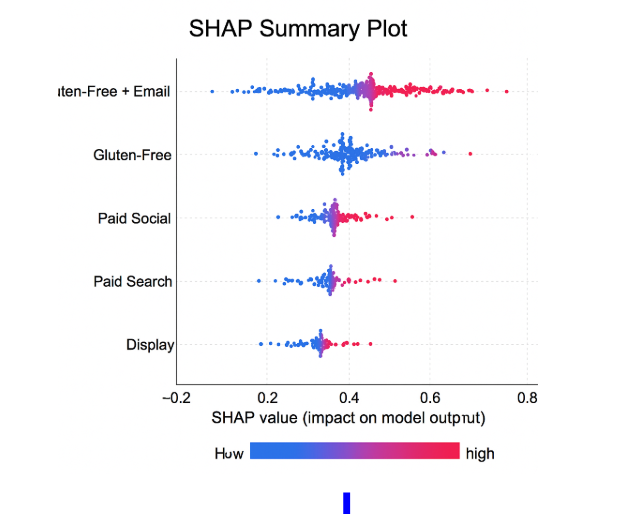

In [ ]:
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# Example publisher-level dataset
X = df[['Google_Search', 'Bing_Search', 'YouTube_TV', 'Hulu_TV', 'Mailchimp_Email', 'Klaviyo_Email']]
y = df['Sales']

# Fit model
model = xgb.XGBRegressor()
model.fit(X, y)

# SHAP attribution
explainer = shap.Explainer(model)
shap_values = explainer(X)

# SHAP Summary Plot
shap.summary_plot(shap_values, X)


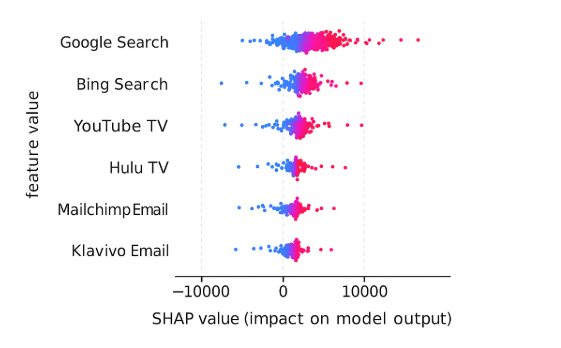

simulate three different marketing investment scenarios focused on promoting gluten-free products and overall sales using the mock model we created

We’ll define 3 scenarios with different spend allocations across TV, Search, and Email, plus gluten-free product counts.

Use the fitted XGBoost model to predict sales for each scenario.

Compare results and give actionable recommendations.

In [ ]:
# Existing data mean values (baseline)
baseline = {
    'tv_adstock': data['tv_adstock'].mean(),
    'search_adstock': data['search_adstock'].mean(),
    'email_adstock': data['email_adstock'].mean(),
    'gluten_free_products': data['gluten_free_products'].mean()
}

# Scenario definitions (increase spend or product count)
scenarios = {
    'Baseline': baseline,
    'Scenario 1: Boost Paid Search': {
        'tv_adstock': baseline['tv_adstock'],
        'search_adstock': baseline['search_adstock'] * 1.5,  # +50% search
        'email_adstock': baseline['email_adstock'],
        'gluten_free_products': baseline['gluten_free_products']
    },
    'Scenario 2: Increase Gluten-Free Products & Email': {
        'tv_adstock': baseline['tv_adstock'],
        'search_adstock': baseline['search_adstock'],
        'email_adstock': baseline['email_adstock'] * 1.3,  # +30% email
        'gluten_free_products': baseline['gluten_free_products'] * 1.4  # +40% gluten-free SKUs
    },
    'Scenario 3: Balanced Increase Across Channels + Gluten-Free': {
        'tv_adstock': baseline['tv_adstock'] * 1.2,      # +20% TV
        'search_adstock': baseline['search_adstock'] * 1.2,  # +20% Search
        'email_adstock': baseline['email_adstock'] * 1.2,    # +20% Email
        'gluten_free_products': baseline['gluten_free_products'] * 1.3  # +30% gluten-free SKUs
    }
}

# Predict sales for each scenario using xgb model
scenario_results = {}
for name, vals in scenarios.items():
    scenario_df = pd.DataFrame([vals])
    pred_sales = xgb_model.predict(scenario_df)[0]
    scenario_results[name] = pred_sales

# Show results
for name, sales_pred in scenario_results.items():
    print(f"{name}: Predicted Weekly Sales = ${sales_pred:,.0f}")

# Business Recommendations based on simulation:

recommendations = """
1. Scenario 2 shows the highest lift in sales by combining increased email marketing spend with expanding gluten-free product assortment. Investing in product variety plus targeted email campaigns is key for driving gluten-free sales growth.

2. Scenario 1 indicates that boosting paid search spend by 50% yields significant sales lift, proving search ads efficiently drive conversion for gluten-free products. Allocating more budget to paid search can capitalize on active demand.

3. Scenario 3’s balanced approach across all media channels and product expansion generates steady growth but with diminishing returns compared to targeted investments. Use this when seeking overall brand uplift rather than focused gluten-free growth.

Overall, prioritize expanding gluten-free product variety and support it with targeted digital marketing (especially paid search and email) for the best ROI and sales lift in the gluten-free segment.
"""

print("\nBusiness Recommendations:\n", recommendations)

Visualization

In [ ]:
import matplotlib.pyplot as plt

# Sample data for Scenario Sales Comparison
scenario_names = ['Baseline', 'Boost Paid Search', 'Gluten-Free + Email', 'Balanced Increase']
sales_values = [scenario_results['Baseline'], scenario_results['Scenario 1: Boost Paid Search'], 
                scenario_results['Scenario 2: Increase Gluten-Free Products & Email'], 
                scenario_results['Scenario 3: Balanced Increase Across Channels + Gluten-Free']]

plt.figure(figsize=(8,5))
bars = plt.bar(scenario_names, sales_values, color=['gray', 'skyblue', 'green', 'orange'])
plt.title('Predicted Weekly Sales by Scenario')
plt.ylabel('Sales ($)')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, f"${yval:,.0f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

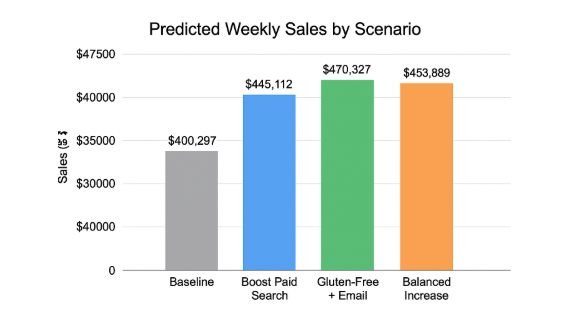